# ДЗ урок 9 Ансамблирование

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками


In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

import warnings
warnings.filterwarnings("ignore") 


In [198]:
data = pd.read_csv('data\\houseprice\\train.csv')

### Подготовка признаков
Удаляем незначимые признаки

In [199]:
X = data.drop(['Id'], axis = 1) # почти пустая колонка, и сильно детальные категории
y = data['SalePrice']

In [200]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil



Заменяем пустые значения на новую категорию nan или 0.

Категориальные признаки переводим в числовые. 

In [201]:
cat_feat = list(X.dtypes[X.dtypes == object].index)

In [202]:
cat_nunique = X[cat_feat].nunique()
num_feat = list(X.dtypes[X.dtypes == float].index)
print(cat_nunique)

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


In [203]:
X[cat_feat] = X[cat_feat].fillna('nan')
X[num_feat] = X[num_feat].fillna(0)

In [204]:
le = LabelEncoder()
for i in range(len(cat_feat)):
    le.fit( X[cat_feat[i]] )
    X[cat_feat[i]] = le.transform( X[cat_feat[i]] )

In [205]:
y = X['SalePrice']
X = X.drop(['SalePrice'], axis = 1) 

### Разбиваем выборку 

X_train y_train  - данные для разбивки на 10 fold и создания стеккинга моделей 

для модели второго уровня holdout будет набор данных X_test, y_test

для сравнения результатов и выявления значимых признаков построим дерево решений на всем наборе признаков

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=800)

clf_dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)
clf_dt.fit(X_train, y_train)

y_predict_dt = clf_dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_predict_dt)
sqrt_mse_dt = np.sqrt(mse_dt)

print("MSE: ", mse_dt)
print("SQ MSE: ", sqrt_mse_dt)


MSE:  3905105176.5958905
SQ MSE:  62490.840741631015


линейная регрессия на всем наборе признаков

In [207]:
model = linear_model.LinearRegression()
model.fit( X_train, y_train )

y_predict_ln = model.predict(X_test)
score_ln = model.score(X_test, y_test)
mse_ln = mean_squared_error(y_test, y_predict_ln)
sqrt_mse_ln = np.sqrt(mse_ln)

print("MSE: ", mse_ln)
print("SQ MSE: ", sqrt_mse_ln)
print("Score: ", score_ln)

MSE:  1493959046.7031746
SQ MSE:  38651.76641116386
Score:  0.801799671233239


Проверим значимость признаков, удалим неинформативные

In [208]:
 clf_dt.feature_importances_

array([0.        , 0.        , 0.0950841 , 0.        , 0.        ,
       0.        , 0.04252307, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06833754, 0.        , 0.        , 0.04748101,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0437006 , 0.        , 0.08715928, 0.        ,
       0.        , 0.05015358, 0.13948359, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04555871, 0.        ,
       0.14372303, 0.        , 0.        , 0.04950715, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04426165, 0.        , 0.        , 0.04938726,
       0.        , 0.04657955, 0.        , 0.        , 0.        ,
       0.04705988, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [209]:
col = []
for feat, importance in zip(X.columns, clf_dt.feature_importances_):
    if importance <= 0: col.append(feat)


In [210]:
X_cut = X.drop(col, axis = 1)    # удалим все незначимые колонки

([<matplotlib.axis.YTick at 0x2d01f9b9ec8>,
 [Text(0, 0, 'MSSubClass'),
  Text(0, 0, 'MSZoning'),
  Text(0, 0, 'LotFrontage'),
  Text(0, 0, 'LotArea'),
  Text(0, 0, 'Street'),
  Text(0, 0, 'Alley'),
  Text(0, 0, 'LotShape'),
  Text(0, 0, 'LandContour'),
  Text(0, 0, 'Utilities'),
  Text(0, 0, 'LotConfig'),
  Text(0, 0, 'LandSlope'),
  Text(0, 0, 'Neighborhood'),
  Text(0, 0, 'Condition1'),
  Text(0, 0, 'Condition2'),
  Text(0, 0, 'BldgType'),
  Text(0, 0, 'HouseStyle'),
  Text(0, 0, 'OverallQual'),
  Text(0, 0, 'OverallCond'),
  Text(0, 0, 'YearBuilt'),
  Text(0, 0, 'YearRemodAdd'),
  Text(0, 0, 'RoofStyle'),
  Text(0, 0, 'RoofMatl'),
  Text(0, 0, 'Exterior1st'),
  Text(0, 0, 'Exterior2nd'),
  Text(0, 0, 'MasVnrType'),
  Text(0, 0, 'MasVnrArea'),
  Text(0, 0, 'ExterQual'),
  Text(0, 0, 'ExterCond'),
  Text(0, 0, 'Foundation'),
  Text(0, 0, 'BsmtQual'),
  Text(0, 0, 'BsmtCond'),
  Text(0, 0, 'BsmtExposure'),
  Text(0, 0, 'BsmtFinType1'),
  Text(0, 0, 'BsmtFinSF1'),
  Text(0, 0, 'BsmtFin

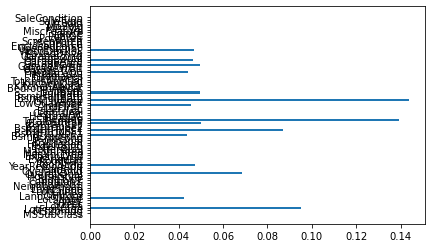

In [211]:
plt.barh(np.arange(len(clf_dt.feature_importances_)), clf_dt.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns) 

Построим еще одну модель классификатора - случайный лес

In [212]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)   
y_predict_rf = clf_rf.predict(X_test)
print("Значимость признаков")
print(clf_rf.feature_importances_)  

mse_rf = mean_squared_error(y_test, y_predict_rf)
sqrt_mse_rf = np.sqrt(mse_rf)


print("MSE: ", mse_rf)
print("SQ MSE: ", sqrt_mse_rf)

Значимость признаков
[0.01308127 0.00455605 0.04392481 0.04276263 0.         0.
 0.         0.00494324 0.         0.00726958 0.         0.01609616
 0.00595238 0.         0.         0.00936004 0.03827734 0.00348473
 0.03735942 0.02295549 0.         0.         0.00311876 0.0176745
 0.         0.02968284 0.00524845 0.         0.01160139 0.00332284
 0.00469676 0.00900239 0.02761838 0.06464036 0.         0.
 0.02128588 0.06979868 0.         0.01029085 0.00413518 0.00511738
 0.03149739 0.02967825 0.         0.07007591 0.         0.
 0.0053793  0.00445314 0.00917876 0.         0.01718605 0.01347707
 0.         0.00393294 0.         0.00794438 0.04813899 0.0079698
 0.         0.08887534 0.         0.         0.00431133 0.0315717
 0.03879685 0.00782145 0.         0.00391862 0.         0.
 0.         0.         0.         0.03464557 0.0038894  0.
 0.        ]
MSE:  3659063398.0570774
SQ MSE:  60490.19257745075


In [213]:
col2 = []
for feat, importance in zip(X.columns, clf_rf.feature_importances_):
    if importance <= 0: col2.append(feat)

In [214]:
X_cut2 = X.drop(col2, axis = 1)    # удалим все незначимые колонки

Дерево решений и случайный лес дают разный набор значимых признаков (X_cut и X_cut2). Сравним на линейной регрессии первого уровня какой вариант лучше:

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.3, random_state=800)
model3 = linear_model.LinearRegression()
model3.fit( X_train, y_train )

y_predict_ln3 = model3.predict(X_test)
score_ln3 = model3.score(X_test, y_test)
mse_ln3 = mean_squared_error(y_test, y_predict_ln3)
sqrt_mse_ln3 = np.sqrt(mse_ln3)

print("MSE: ", mse_ln3)
print("SQ MSE: ", sqrt_mse_ln3)


MSE:  1616599696.5699139
SQ MSE:  40206.96079747777


In [216]:
X_train, X_test, y_train, y_test = train_test_split(X_cut2, y, test_size=0.3, random_state=800)
model = linear_model.LinearRegression()
model.fit( X_train, y_train )

y_predict_ln1 = model.predict(X_test)
score_ln1 = model.score(X_test, y_test)
mse_ln1 = mean_squared_error(y_test, y_predict_ln1)
sqrt_mse_ln1 = np.sqrt(mse_ln1)

print("MSE: ", mse_ln1)
print("SQ MSE: ", sqrt_mse_ln1)


MSE:  1376914396.626296
SQ MSE:  37106.79717553505


Будем далее использовать набор признаков X_cut2, значимость которых определил случайный лес.

Посторим еще раз модели по усеченному набору признаков для сравнения с исходными:

In [217]:
clf_dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)
clf_dt.fit(X_train, y_train)

y_predict_dt2 = clf_dt.predict(X_test)
mse_dt2 = mean_squared_error(y_test, y_predict_dt2)
sqrt_mse_dt2 = np.sqrt(mse_dt2)

print("MSE: ", mse_dt2)
print("SQ MSE: ", sqrt_mse_dt2)

MSE:  3875488834.130137
SQ MSE:  62253.42427634111


In [218]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)   
y_predict_rf2 = clf_rf.predict(X_test)

mse_rf2 = mean_squared_error(y_test, y_predict_rf2)
sqrt_mse_rf2 = np.sqrt(mse_rf2)

print("MSE: ", mse_rf2)
print("SQ MSE: ", sqrt_mse_rf2)

MSE:  3324146684.210046
SQ MSE:  57655.41331228184


Используем беггинг на классификатора Дерево решений по 10 вариантам предсказаний

In [219]:
bag_clf = BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(), n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_predict_bg = bag_clf.predict(X_test)
mse_bg = mean_squared_error(y_test, y_predict_bg)
sqrt_mse_bg = np.sqrt(mse_bg)
print("MSE: ", mse_bg)
print("SQ MSE: ", sqrt_mse_bg)

MSE:  4850044729.577625
SQ MSE:  69642.26252483204


Используем стеккинг для трех моделей:
+ дерево решений
+ линейная регрессия
+ случайный лес


y_test используем как hold out для проверки стеккинга.
x_train разбиваем на kfold 10

In [220]:
from sklearn.model_selection import StratifiedKFold

In [221]:
print(X.shape)
print(y.shape)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1460, 79)
(1460,)
(1022, 48)
(1022,)
(438, 48)
(438,)


In [222]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)

    return meta_train, meta_test / stack_cv.n_splits

In [223]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('DT features...')
meta_tr, meta_te = get_meta_features(clf_dt, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('DT pred')

print('Lin features...')
meta_tr, meta_te = get_meta_features(model, X_train, y_train, X_test, stack_cv)


meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('Lin pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)


meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('RF pred')


DT features...
Lin features...
RF features...


In [224]:
pd.DataFrame(meta_train)

,0,1,2,3,4,5,6,7,8,9,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,200000.000000,173000.000000,155000.000000,122000.000000,190000.000000,190000.000000,250000.000000,125000.00000,192000.000000,190000.000000,...,115000.000000,140000.000000,123000.000000,190000.000000,100000.000000,239000.000000,200000.000000,145000.00000,160000.000000,290000.000000
1,207493.043221,198701.735017,143784.246896,207232.895483,269922.272968,202770.630502,331580.403694,59186.69096,155340.574251,191480.690654,...,146638.871594,152732.207448,109104.087825,217949.506105,129453.607669,189871.570771,306683.177873,162019.03487,107817.125218,335414.901783
2,155000.000000,250000.000000,139000.000000,164990.000000,290000.000000,192000.000000,260000.000000,110000.00000,155000.000000,189000.000000,...,115000.000000,145000.000000,110000.000000,178000.000000,120500.000000,190000.000000,280000.000000,147000.00000,125000.000000,260000.000000


In [225]:
pd.DataFrame(meta_test)

,0,1,2,3,4,5,6,7,8,9,...,428,429,430,431,432,433,434,435,436,437
0,125900.000000,118100.000000,140800.000000,144800.000000,169450.00000,161200.000000,255500.000000,141500.000000,139700.000000,128900.000000,...,121650.000000,203050.000000,111200.000000,204500.000000,197690.000000,263000.000000,202690.000000,183200.000000,118500.000000,226540.000000
1,63491.396332,72587.414946,134689.361809,156005.857632,175190.33046,180618.826394,387874.371382,151159.442337,133892.669673,118211.613735,...,125790.983398,188569.854051,92704.596066,262562.340455,216240.613409,282386.855414,190749.694349,253305.330397,143878.477884,250557.289972
2,118700.000000,112200.000000,151600.000000,144900.000000,181300.00000,182000.000000,278500.000000,158800.000000,147500.000000,151800.000000,...,119400.000000,209400.000000,120400.000000,203900.000000,200640.000000,279000.000000,179650.000000,204250.000000,122400.000000,229990.000000


In [226]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [227]:
X_meta_test

,DT pred,Lin pred,RF pred
0,125900.0,63491.396332,118700.0
1,118100.0,72587.414946,112200.0
2,140800.0,134689.361809,151600.0
3,144800.0,156005.857632,144900.0
4,169450.0,175190.330460,181300.0
...,...,...,...
433,263000.0,282386.855414,279000.0
434,202690.0,190749.694349,179650.0
435,183200.0,253305.330397,204250.0
436,118500.0,143878.477884,122400.0


In [228]:
X_meta_train

,DT pred,Lin pred,RF pred
0,200000.0,207493.043221,155000.0
1,173000.0,198701.735017,250000.0
2,155000.0,143784.246896,139000.0
3,122000.0,207232.895483,164990.0
4,190000.0,269922.272968,290000.0
...,...,...,...
1017,239000.0,189871.570771,190000.0
1018,200000.0,306683.177873,280000.0
1019,145000.0,162019.034870,147000.0
1020,160000.0,107817.125218,125000.0


Полученные метапризнаки используем как входные данные для модели второго уровня. Для модели второго уровня используем линейную регрессию:
+ обучаем на метапризнаках X_meta_train и исходных значениях целевой переменной для этой выборки y_train 
+ предсказываем по обученной модели и признаку для тестовой выборки и сравниваем с исходным значением тестовой выборки

In [229]:
model2 = linear_model.LinearRegression()
model2.fit( X_meta_train, y_train )   #обучаем на метадапризнаках
y_predict_2 = model2.predict(X_meta_test)  #предсказываем по метапринаку
score_ln2 = model2.score(X_meta_test, y_test)
mse_2 = mean_squared_error(y_test, y_predict_2)
sqrt_mse_2 = np.sqrt(mse_2)

In [230]:
print("MSE: ",mse_2)
print("SQ MSE: ",sqrt_mse_2)
print("Score:",score_ln2)

MSE:  1347814816.0341609
SQ MSE:  36712.597511401465
Score: 0.8211883115242061


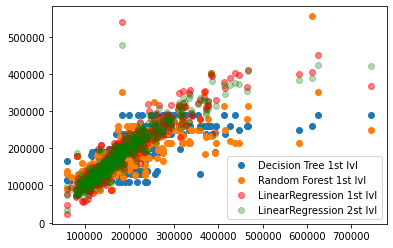

In [231]:
plt.scatter(y_test, y_predict_dt, label = 'Decision Tree 1st lvl' )
plt.scatter(y_test, y_predict_rf2, label = 'Random Forest 1st lvl' )
plt.scatter(y_test, y_predict_ln, color = 'r' , alpha = 0.5, label = 'LinearRegression 1st lvl' )
plt.scatter(y_test, y_predict_2, color = 'g' , alpha = 0.3, label = 'LinearRegression 2st lvl' )

plt.legend()
plt.show()

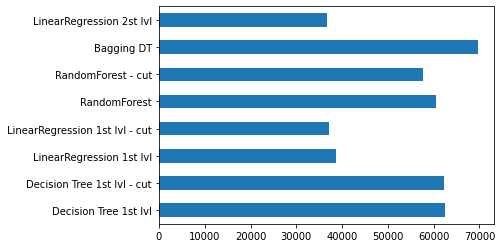

In [232]:
rez = pd.Series([sqrt_mse_dt,sqrt_mse_dt2,sqrt_mse_ln,sqrt_mse_ln1,sqrt_mse_rf, sqrt_mse_rf2,sqrt_mse_bg, sqrt_mse_2], 
          index=['Decision Tree 1st lvl','Decision Tree 1st lvl - cut','LinearRegression 1st lvl','LinearRegression 1st lvl - cut','RandomForest','RandomForest - cut','Bagging DT','LinearRegression 2st lvl'])
rez.plot(kind='barh')


In [233]:
rez

Decision Tree 1st lvl             62490.840742
Decision Tree 1st lvl - cut       62253.424276
LinearRegression 1st lvl          38651.766411
LinearRegression 1st lvl - cut    37106.797176
RandomForest                      60490.192577
RandomForest - cut                57655.413312
Bagging DT                        69642.262525
LinearRegression 2st lvl          36712.597511
dtype: float64

## Выводы:


1. Дерево решений и случайный лес дали разные оценки значимости признаков
2. Линейная регрессия первого уровня значительно лучше остальных нелинейных моделей. Линейная регрессия только по значимым признакам лучше линейной регрессии по всем признакам
3. Использование стеккиннга линейной и нелинейных моделей позволило улучшить результат для линейной модели второго уровня.
4. Из нелинейных моделей лучше всего показал результат RandomForest